# Predicting Churn for Bank Customers

## Author: Emmanuel Edouard Moutoussamy (https://tinyurl.com/3f7ddem8)

The goal of this project is to (1) detect the descriptor that influence the costumer churn and (2) build a model to predict the costumer churn.

### What is costumer churn ?


Summary:
- Data exploration
- Data preprocessing
- Modeling


The dataset used is availbale on Kaggle: https://tinyurl.com/ud43n28s


## Necessary module import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score 

## Functions

In [2]:
def MakeMeADonut(labels, data_count):
    """
    Plot a donut chart. Same as a pie chart but cooler ;)
    
    :param labels: labels for the donut chart
    :param data_count: count data for the donut chart
    :return: plot the donut chart
    """
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data_count,explode=(0.03,0.03),labels=labels,
                                      colors=['#982041','#2E5C91'],autopct='%1.1f%%',
                                      shadow=True,pctdistance=0.4)

    plt.setp(texts, size=18)
    plt.setp(autotexts, size=18)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.tight_layout()
    plt.show()

    
    
    

def BuildMatrixCategorical(dataframe,categorical_descriptors):
    """
    Make a np array with the percentage of left and retained 
    customer.
    
    :param dataframe: original pandas dataframe
    :param categorical_descriptors: list of all categorical descriptors
    :return: np array with the percentage of left and retained
    """
    exited = dataframe[dataframe["Exited"] == 1]
    retained = dataframe[dataframe["Exited"] == 0]

    flag = 0
    all_descriptors = []

    for descriptor in categorical_descriptors:
        for descriptor_value in df[descriptor].unique():

            total = df[df[descriptor] == descriptor_value].shape[0]
            state = [((exited[exited[descriptor] == descriptor_value].shape[0])/total)*100,
                     ((retained[retained[descriptor] == descriptor_value].shape[0])/total)*100]

            if descriptor_value == 1:
                descriptor_value = "yes"
            elif descriptor_value == 0:
                descriptor_value = "no"
            
            all_descriptors.append("{0} : {1}".format(descriptor,descriptor_value))


            if flag == 0:
                matrix_categorical = np.array(state)
                flag = 1
            else:
                matrix_categorical = np.vstack((matrix_categorical,state))


    matrix_categorical = pd.DataFrame(matrix_categorical,\
                                      columns = ["Left","Retained"],\
                                      index = all_descriptors)
    
    return matrix_categorical


def PlotHeatMap(matrix_categorical):
    """
    Plot the heatmap
    :param matrix_categorical: np array with the percentage of left and retained
    """
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    hm = sns.heatmap(matrix_categorical,annot =True,annot_kws={"size": 14},\
                     cmap="Spectral",cbar_kws={'label': 'Percent %'})

    hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
    hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)
    ax.figure.axes[-1].yaxis.label.set_size(20)

    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20)
    
    ax.hlines([2, 5, 7], *ax.get_xlim(),linewidth=10, color='w')
    

    plt.show()

def DensityPlot(df, descriptor):
    plt.figure(figsize=(16,8))


    print("""

    The avgerage age of churned costumers is {0} against {1} for the retained costumers

    """.format(round(np.mean(df[df["Exited"] == 1][descriptor]),2),\
               round(np.mean(df[df["Exited"] == 0][descriptor]),2)))

    sns.kdeplot(df[df["Exited"] == 1][descriptor], shade=True,color = '#982041')
    sns.kdeplot(df[df["Exited"] == 0][descriptor], shade=True,color = '#2E5C91')
    plt.legend(["Churned","Retained"],fontsize=16)
    plt.xlabel(descriptor,fontsize=16)
    plt.ylabel("Density",fontsize=16)
    plt.xticks(fontsize= 14 )

    plt.show()

    
    

def ModelAssessment(y_obs,y_pred):
    """
    """
    cm = confusion_matrix(y_obs,y_pred)
    
    sns.heatmap(cm,cmap="YlGnBu",annot=True)
    plt.show()
    print(classification_report(y_obs,y_pred))



### Loading dataset:

In [3]:
df = pd.read_csv('input/Churn_Modelling.csv', delimiter=',')

## 1. Data exploration

First let's see what the dataset look like:

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
print("\n The dataset contains {0} rows and {1} columns\n ".format(df.shape[0],df.shape[1]))


 The dataset contains 10000 rows and 14 columns
 


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


The dataset conatins 14 descriptors which can be int or string.

In [7]:
# is there missing values on the dataset:

df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There is no missing values on the dataset (Good news 🥳)

However, we can see that some descriptors are useless for the purpose of this project. Indeed, the row number, the customer id, and the surname do not play a role in the customer churn. These descriptors will be remove for the rest of the project

In [8]:
# Remove RowNumber, CustomerId  and Surname
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)


#let's look at the dataset:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In this dataset we can distinguished two type of descriptors: the categorical and the continuous descriptors. Let's define them for the rest of the proejct:

In [9]:
categorical_descriptors = ["Gender","Geography","HasCrCard","IsActiveMember"]
continuous_descriptors = ["CreditScore", "Age", "Tenure", "Balance","NumOfProducts", "EstimatedSalary"]

### Data visualisation

First, I look at the proportion of customers who left the company on this dataset:

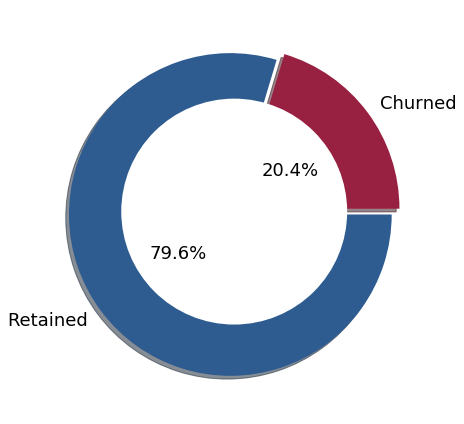

In [10]:
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]

MakeMeADonut(['Churned', 'Retained'], sizes)

It appears that 20.4% of the customers left the bank in this dataset.

### Let's look at the relation between the categorical variable and the churn status

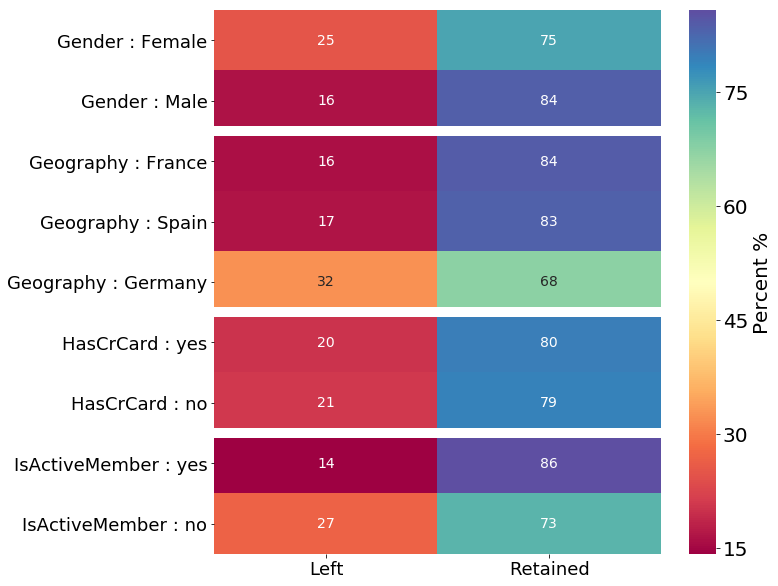

In [11]:
matrix_categorical = BuildMatrixCategorical(df,categorical_descriptors)
PlotHeatMap(matrix_categorical)


Here, the catgorical variables gives us some interresting information:

1. The churn rate is higher for women than men

2. The churn rate is higher for the german costumers (highest churn rate). Frech and Spanish customers have the same churn rate.

3. Having a credit do not to be a key feature for the customer churn

4. As expected, non-active members present a higher chrun rate.

now let's test the correlation:

In [12]:
from scipy.stats import chi2_contingency

chi2_array, p_array = [], []

for column in categorical_descriptors:

    crosstab = pd.crosstab(df[column], df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical_descriptors,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
1,Geography,301.255337,3.830318e-66
3,IsActiveMember,242.985342,8.785858e-55
0,Gender,112.918571,2.248210e-26
2,HasCrCard,0.471338,4.923724e-01


### Let's look at the relation between the categorical variable and the churn status

[]

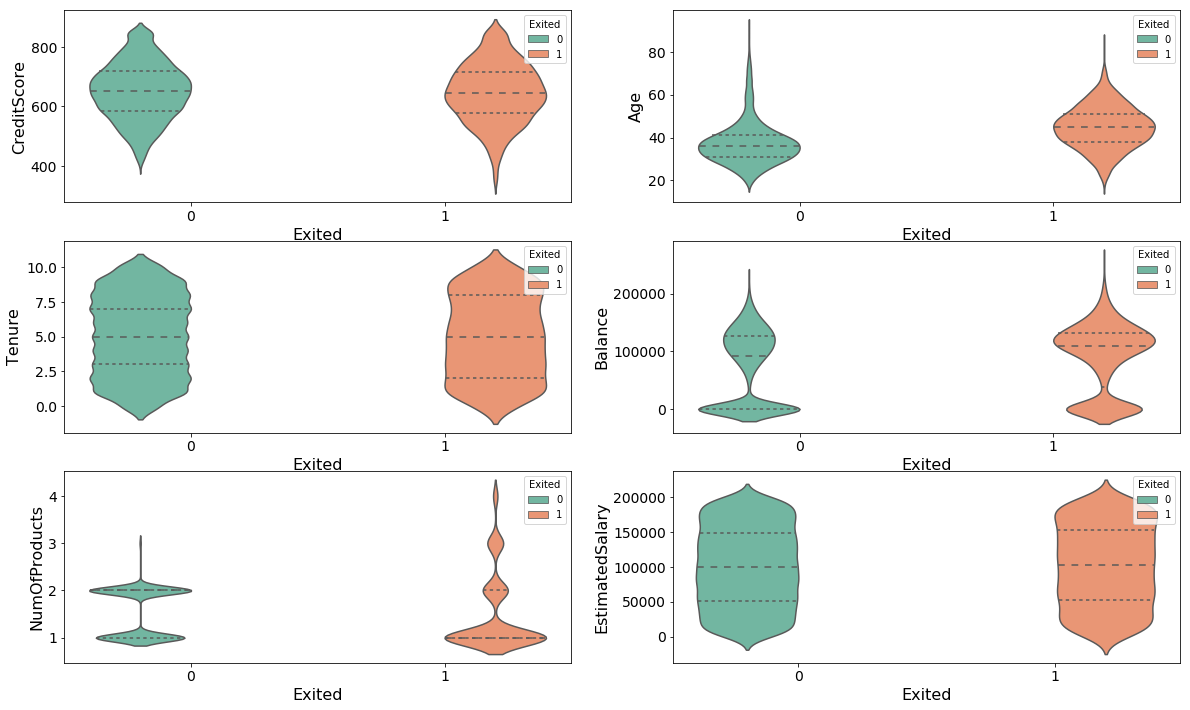

In [13]:
x = 0
y = 0

fig, axarr = plt.subplots(3, 2, figsize=(20, 12))

for descriptor in continuous_descriptors:
    sns.violinplot(y=descriptor,x = 'Exited',palette="Set2", hue = 'Exited',data = df,inner="quartile", ax=axarr[x][y])
    axarr[x][y].tick_params(axis='both', which='major', labelsize=14)
    axarr[x][y].yaxis.label.set_size(16)
    axarr[x][y].xaxis.label.set_size(16)



    if y ==0:
        y = 1
    elif y == 1:
        x += 1
        y = 0
        


plt.plot()

Here, the continuous variables gives us some interresting information:

1. The credits score do not seems to be different between the churned and retained costumers.

2. The average age of the retained costumers seems to be lower than the churned costumers.

3. The tenure do not seems to be different between the churned and retained costumers.

4. We can see a clear difference in the balance of the churned and retained costumers.

5. The retained costumers present mostly one or two products.

6. The estimated salary do not seems to be different between the churned and retained costumers.



    The avgerage age of churned costumers is 44.84 against 37.41 for the retained costumers

    


/Users/nma092/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


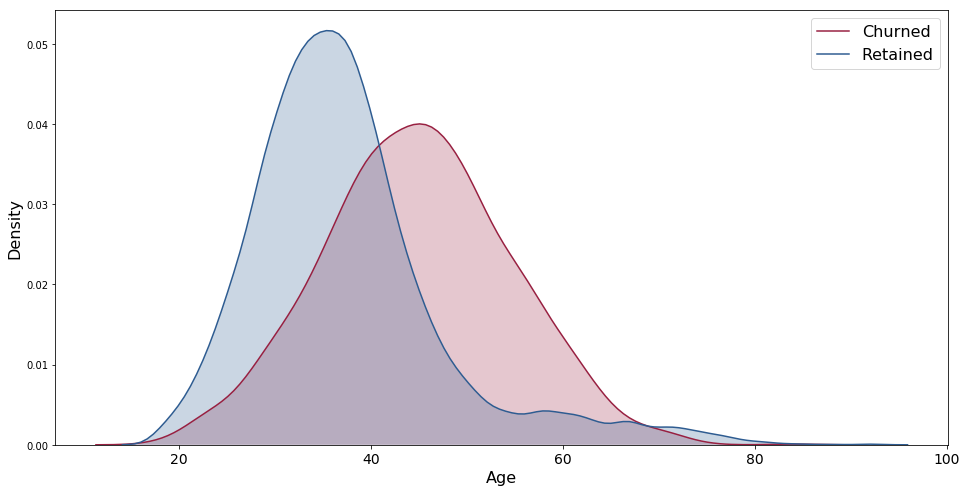

In [14]:
DensityPlot(df, "Age")

Indeed, the average age of the cherned costumers is higher than the retained costumers (37 vs 45).
This information is crucial for the modeling.



    The avgerage age of churned costumers is 91108.54 against 72745.3 for the retained costumers

    


/Users/nma092/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


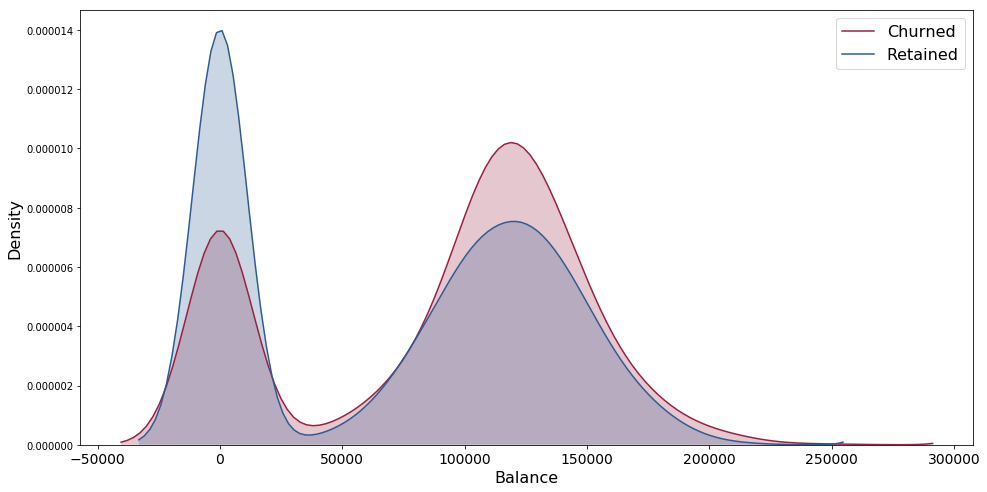

In [15]:
DensityPlot(df, "Balance")

For the balcance, we can see two peaks both distributions: 0 and around 125 000.
we can see that there are more costumers with a balance = 0 that stayed on the bank. This is even more visble on the following barplot:

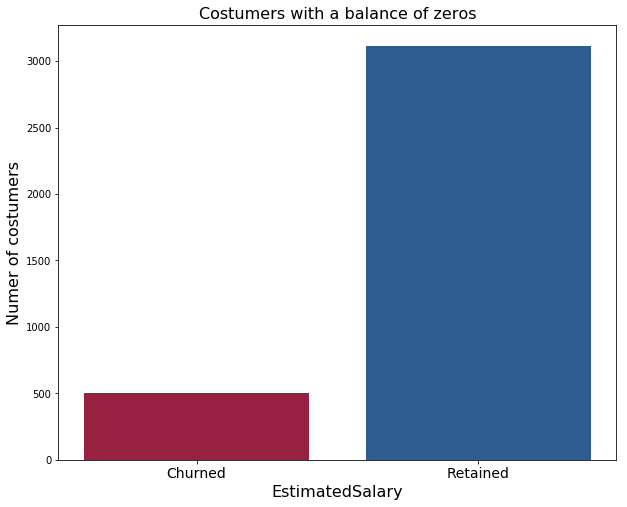

In [16]:
plt.figure(figsize=(10,8))


balance_zeros = [df[df["Exited"] == 1]["Balance"].value_counts()[0.0],\
                 df[df["Exited"] == 0]["Balance"].value_counts()[0.0]]

plt.bar([1,2], balance_zeros,color=['#982041','#2E5C91'])
plt.xticks([1,2], ["Churned","Retained"])
plt.xlabel(descriptor,fontsize=16)
plt.ylabel("Numer of costumers",fontsize=16)
plt.xticks(fontsize= 14 )
plt.title("Costumers with a balance of zeros",fontsize=16)
plt.show()

## 2. Descriptor  Engineering

I noticed that the costumers with a non-null balance are part of the retained costumers. Let's make a categorical variable based on this information.


In [17]:
df['balnace_zeros'] = df.apply(lambda x: 1 if x.Balance == 0.0 else 0, axis=1)
df['highNumProduct'] = df.apply(lambda x: 1 if x.NumOfProducts > 2 else 0, axis=1)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balnace_zeros,highNumProduct
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0


## 3. Data preprocessing

addressing the imbalance data problem:

### Encoding of categorical descriptors

Based of the last analysis we point out some non-essential features: 'Tenure', 'HasCrCard', 'EstimatedSalary'

Let's drop them:


In [18]:
df = df.drop(['Tenure', 'HasCrCard', 'EstimatedSalary'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
CreditScore       10000 non-null int64
Geography         10000 non-null object
Gender            10000 non-null object
Age               10000 non-null int64
Balance           10000 non-null float64
NumOfProducts     10000 non-null int64
IsActiveMember    10000 non-null int64
Exited            10000 non-null int64
balnace_zeros     10000 non-null int64
highNumProduct    10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.3+ KB


In [19]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

df['Geography'] = df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})


df.head()

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited,balnace_zeros,highNumProduct
0,619,0,0,42,0.00,1,1,1,1,0
1,608,0,0,41,83807.86,1,1,0,0,0
2,502,0,0,42,159660.80,3,0,1,0,1
3,699,0,0,39,0.00,2,0,0,1,0
4,850,0,0,43,125510.82,1,1,0,0,0


### Scaling the continuous descriptors

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()


scl_columns = ['CreditScore', 'Age', 'Balance']
df[scl_columns] = scaler.fit_transform(df[scl_columns])


In [21]:
df.head()

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited,balnace_zeros,highNumProduct
0,0.538,0,0,0.324324,0.000000,1,1,1,1,0
1,0.516,0,0,0.310811,0.334031,1,1,0,0,0
2,0.304,0,0,0.324324,0.636357,3,0,1,0,1
3,0.698,0,0,0.283784,0.000000,2,0,0,1,0
4,1.000,0,0,0.337838,0.500246,1,1,0,0,0


In [22]:
#split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', axis=1), df.Exited, test_size = 0.20)

#over = SMOTE(sampling_strategy='auto', random_state=random_state)
#X_train, y_train = over.fit_resample(X_train, y_train)

#y_train.value_counts()

## Models Building

{'C': 10, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      6376
           1       0.70      0.35      0.46      1624

    accuracy                           0.84      8000
   macro avg       0.78      0.65      0.68      8000
weighted avg       0.82      0.84      0.81      8000

              precision    recall  f1-score   support

           0       0.85      0.96      0.91      1587
           1       0.73      0.37      0.49       413

    accuracy                           0.84      2000
   macro avg       0.79      0.66      0.70      2000
weighted avg       0.83      0.84      0.82      2000



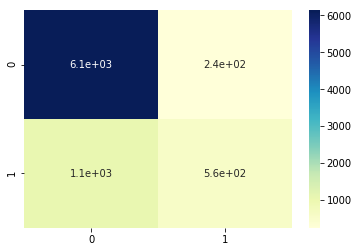

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      6376
           1       0.70      0.35      0.46      1624

    accuracy                           0.84      8000
   macro avg       0.78      0.65      0.68      8000
weighted avg       0.82      0.84      0.81      8000



In [23]:
param_grid = {'C': [0.1,0.5,1,10,50,100],
              'max_iter': [250],
              'fit_intercept':[True],
              'intercept_scaling':[1],
              'penalty':['l2'],
              'tol':[0.00001,0.0001,0.000001]}

lr_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)

lr_Grid.fit(X_train,y_train)

print(lr_Grid.best_params_)


# Fit primal logistic regression
lr_best = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='multinomial',n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)





lr_best.fit(X_train,y_train)
y_pred_train = lr_best.predict(X_train)
y_pred_test = lr_best.predict(X_test)


print(classification_report(y_train,y_pred_train))
print(classification_report(y_test,y_pred_test))

ModelAssessment(y_train,y_pred_train)


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Fit random forest classifier
param_grid = {'bootstrap': [True, False],
 'max_depth': [3, 5, 6, 7, 8],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 3, 5],
 'min_samples_split': [2, 3, 5],
 'n_estimators': [50,100]}

RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(X_train,y_train)




KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      6376
           1       0.85      0.52      0.64      1624

    accuracy                           0.88      8000
   macro avg       0.87      0.75      0.79      8000
weighted avg       0.88      0.88      0.87      8000

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1587
           1       0.77      0.47      0.59       413

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



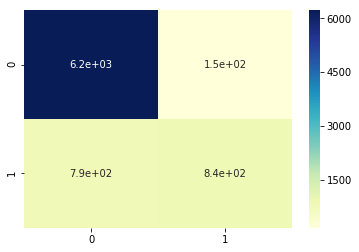

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      6376
           1       0.85      0.52      0.64      1624

    accuracy                           0.88      8000
   macro avg       0.87      0.75      0.79      8000
weighted avg       0.88      0.88      0.87      8000



In [26]:
from sklearn.ensemble import RandomForestClassifier

# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8],
 'max_features': [2,4,6,7,8,9],
 'min_samples_leaf': [2, 3, 5],
 'min_samples_split': [3, 5, 6, 7],
 'n_estimators': [50,100]}

RFgrid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RFgrid.fit(X_train,y_train)



y_pred_train = RFgrid.predict(X_train)
y_pred_test = RFgrid.predict(X_test)


print(classification_report(y_train,y_pred_train))
print(classification_report(y_test,y_pred_test))

ModelAssessment(y_train,y_pred_train)

